<a href="https://colab.research.google.com/github/msandeep27/Pytorch-Grad-Cam/blob/master/Pytorch_Grad_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json


In [0]:
!kaggle competitions download -c dogs-vs-cats

sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
test1.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!mkdir '../data'
!unzip --qq 'test1.zip' -d '../data'
!unzip --qq 'train.zip' -d '../data'

mkdir: cannot create directory ‘../data’: File exists
replace ../data/test1/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace ../data/train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
!pip3 install torch torchvision

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision.datasets.folder import IMG_EXTENSIONS
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import torch.nn.functional as F
import cv2

plt.ion()   # interactive mode
import os
defaultPath='../data'

In [0]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [0]:
train_dir = '../data/train'
test_dir = '../data/test1'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = data_transforms)
dogs = CatDogDataset(dog_files, train_dir, transform = data_transforms)

datasets = ConcatDataset([cats, dogs])

In [0]:
valid_size=0.2
data_dir = '../data'
num_train = len(datasets)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train))
np.random.shuffle(indices)

train_idx,test_idx=indices[split:],indices[:split]
trainSampler=SubsetRandomSampler(train_idx)
testSampler=SubsetRandomSampler(test_idx)
trainloaders = torch.utils.data.DataLoader(datasets, batch_size=4,sampler=trainSampler,num_workers=4)
testloaders = torch.utils.data.DataLoader(datasets, batch_size=4,sampler=testSampler,num_workers=4)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


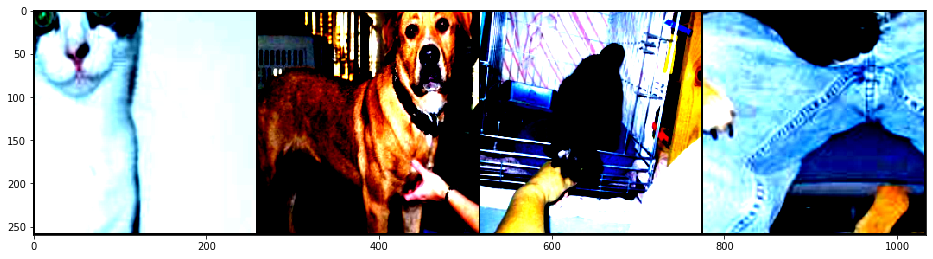

In [0]:
samples, labels = iter(trainloaders).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:24])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [0]:
!tree -d ../data

/bin/bash: tree: command not found


In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = torchvision.models.vgg16(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        #self.classifier = nn.Sequential(nn.Linear(512, 64),
        ##                         nn.ReLU(),
        #                         nn.Dropout(0.2),
        ##                         nn.Linear(256, 2),
        #                         nn.LogSoftmax(dim=1))
        # get the classifier of the vgg19
        #self.classifier = nn.Linear(4096, 8)
        
        # placeholder for the gradients
        self.fc2 = nn.Linear(8192, 2)
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        #x = self.classifier(x)
        #num_ftrs = x.fc.in_features
        x = F.relu(self.fc2(x))
        #x.classifier = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [0]:
# initialize the VGG model
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the image from the dataloader
vgg

VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPoo

In [0]:
def Visualize_Output(pred,img_tr,img_path):

  # get the gradient of the output with respect to the parameters of the model

  # pull the gradients out of the model
  gradients = vgg.get_activations_gradient()
  #print(gradients)
  # pool the gradients across the channels
  pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

  # get the activations of the last convolutional layer
  activations = vgg.get_activations(img_tr).detach()

  # weight the channels by corresponding gradients
  for i in range(512):
      activations[:, i, :, :] *= pooled_gradients[i]
      
  # average the channels of the activations
  heatmap = torch.mean(activations, dim=1).squeeze()

  # relu on top of the heatmap
  # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
  heatmap = np.maximum(heatmap, 0)

  # normalize the heatmap
  heatmap /= torch.max(heatmap)

  # draw the heatmap
  #plt.matshow(heatmap.squeeze())
  img = cv2.imread(img_path)
  #plt.imshow(img)
  #heatmap.shape,img.shape
  heatmap=heatmap.numpy()
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap1)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  #superimposed_img = heatmap1 * 0.4 + img
  superimposed_img = cv2.addWeighted(img,0.9,heatmap1,0.4,10)
  stack_imag=np.hstack((img,superimposed_img,heatmap1))
  return stack_imag

In [0]:
camdataset = CatDogDataset(dog_files[5:6], train_dir, transform = data_transforms)
#cat_files[:1],train_dir
camloaders = torch.utils.data.DataLoader(dataset=camdataset, shuffle=False, batch_size=1)
img, _ = next(iter(camloaders))

# get the most likely prediction of the model
pred = vgg(img)
pred_val=pred.argmax(dim=1)

pred,pred_val,dog_files[5:6]
#

(tensor([[0.1879, 0.0000]], grad_fn=<ReluBackward0>),
 tensor([0]),
 ['dog.1931.jpg'])

In [0]:
pred[:,pred_val].backward()

output_img=Visualize_Output(pred,img,'../data/train/dog.1931.jpg')


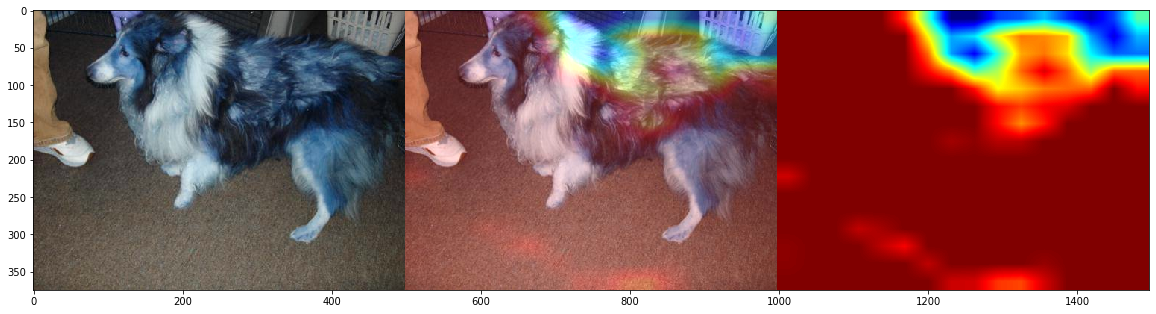

In [0]:
plt.figure(figsize=(20,20))
plt.imshow(output_img)